# Announcements

- MVP

# Unsupervised Learning

In the Supervised Learning paradigm, we have a collection of observations (our data), each with a set of features and a particular variable of interest, i.e., the "target" (in regression) or "label" (in classification) which we aim to predict.

In the **Unsupervised Learning** paradigm, there is no particular variable of interest. In this way, the goal is not to predict an aspect of, but rather **to organize the data**, and subsequently act on our organization. Most forms of unsupervised learning can be categorized as one of the following:

- **Dimensionality Reduction.** Use relationships between rows and columns to represent the data with fewer columns.
- **Clustering:** Group rows of data into categories based on their featuers ("similar" data are placed into groups).
- **Recommendation.** Use the above two strategies to acertain what might be a good recommendation to someone with access to the features of data in question.

And, all three of these are based on the notion of "**similarity**".

*With unsupervised learning, we will mainly use the `.transform()` and `.fit_transform()` methods in Scikit-Learn that we saw in the lab on NLP methods.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

sns.set_theme(context='notebook', style='whitegrid', font_scale=1.2)

## Train-Test Split

Unsupervised Learning is still a form of "machine" learning, so we grant that our work is meant to generalize to data that is yet unseen. So, we should still have a hold out (or "test") set of data on which to evaluate our models later.

In this lab, we'll be using a collection of beer review data.

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
# we can use `read_csv` to read the compressed csv file
url = "https://raw.githubusercontent.com/leontoddjohnson/datasets/main/data/beer_reviews/beer_reviews.csv.zip"
df_raw = pd.read_csv(url, compression='zip', low_memory=False)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1586614 non-null  int64  
 1   brewery_name        1586599 non-null  object 
 2   review_time         1586614 non-null  int64  
 3   review_overall      1586614 non-null  float64
 4   review_aroma        1586614 non-null  float64
 5   review_appearance   1586614 non-null  float64
 6   review_profilename  1586266 non-null  object 
 7   beer_style          1586614 non-null  object 
 8   review_palate       1586614 non-null  float64
 9   review_taste        1586614 non-null  float64
 10  beer_name           1586614 non-null  object 
 11  beer_abv            1518829 non-null  float64
 12  beer_beerid         1586614 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


In [4]:
df_beer_reviews, df_holdout = train_test_split(df_raw, test_size=0.20, random_state=33)

In [5]:
df_beer_reviews.isna().sum()

brewery_id                0
brewery_name             12
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      272
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              54314
beer_beerid               0
dtype: int64

In [6]:
# there are not many NA values compared to all the data, so we drop them
df_beer_reviews.dropna(inplace=True)

In [ ]:
# df_beer_reviews.to_csv('./data/beer_reviews.csv', index=False)
# df_holdout.to_csv('./data/beer_reviews_holdout.csv', index=False)

## The Curse of Dimensionality

As data sets become increasingly wide (i.e., more columns), they in turn become more unweildy. We may want as many columns as possible to maximize the information we have for each observation, but as we do so, we run into a couple of problems:

1. more columns will increase the computational load on any algorithm acting on that data. 
2. high-dimensional spaces quickly become sparse, and require exponentially more data accurately represent a situation.

This phenomenon is commonly called **"The Curse of Dimensionality"**.

## Dimensionality Reduction

We can combat the curse of dimensionality using dimensionality reduction techniques. In dimensionality reduction, we extract latent features in our data that otherwise would go unnoticed (a.k.a., "Feature Extraction"). These latent features retain some acceptable percentage of the information from the original dataset, and we can use a fewer number of them in lieu of the wider dataset we started with. *Note: In a way, classification and regression are extreme forms of dimensionality reduction.*

One of the most common dimensionality reduction techniques is one we've already seen: Principal Components Analysis (PCA) which uses Singular Value Decomposition (SVD). Recall that SVD is a guaranteed decomposition for any rectangular matrix. It creates the following equality:

$$
X = U\Sigma V^\top
$$

In [7]:
from sklearn.decomposition import PCA

### Indexing Entities

We'll start by only considering beer-related columns of data by aggregating the reviews across users. So, if multiple users reviewed a beer, we only need the average review rating(s).

In [8]:
numeric_columns = ['review_overall', 'review_aroma',
                   'review_appearance', 'review_palate', 
                   'review_taste', 'beer_abv']

In [9]:
df_beers = (
    df_beer_reviews
        .groupby(['beer_name', 'beer_beerid', 'brewery_name', 'beer_style'])
        [numeric_columns].mean()
        .reset_index()
)

In [10]:
df_beers.shape

(45516, 10)

In [11]:
print("Number of `beer_beerids`: ", df_beers['beer_beerid'].nunique())
print("Number of `beer_names`: ", df_beers['beer_name'].nunique())

Number of `beer_beerids`:  45516
Number of `beer_names`:  41054


The "names" don't quite match up to their IDs, so we create a unique identifier for each row, and reassign it as the index for the dataframe.

In [12]:
df_beers['beer_id'] = df_beers['beer_name'] + ' (' + df_beers['beer_beerid'].astype(str) + ')'

In [13]:
df_beers['beer_id'].nunique()

45516

In [14]:
df_beers.set_index('beer_id', inplace=True)
df_beers.drop(columns=['beer_beerid', 'beer_name'], inplace=True)

In [15]:
df_beers.drop_duplicates(inplace=True)

Next, we'll reduce our scope to only the top 100 breweries, and the top 100 beer styles.

In [16]:
# Let's just look at the top breweries and the top beer styles
n_breweries = 100
n_beer_styles = 100

# `.value_counts` sorts the series descendingly by default
brewery_popularity = df_beers.brewery_name.value_counts()
top_breweries = brewery_popularity.iloc[:n_breweries].index

beer_style_popularity = df_beers.beer_style.value_counts()
top_beer_styles = beer_style_popularity.iloc[:n_beer_styles].index

df_beers_top = df_beers[(df_beers.brewery_name.isin(top_breweries)) &
                        (df_beers.beer_style.isin(top_beer_styles))].copy()

df_beers_top.shape

(9115, 8)

In [17]:
df_beers_top.head()

,brewery_name,beer_style,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv
beer_id,,,,,,,,
"""12"" Belgian Golden Strong Ale (44353)",Flossmoor Station Restaurant & Brewery,Belgian Strong Pale Ale,4.000000,3.500000,4.500000,5.000000,4.500000,9.0
"""Alt""ered State (11271)",General Lafayette Inn & Brewery,Altbier,3.500000,3.750000,4.000000,4.000000,4.000000,6.8
"""Cellar Reserve"" Triple Gold (25108)",Beer Works,Tripel,4.000000,4.000000,4.000000,4.500000,4.500000,9.0
"""Great Satchmo"" Stout (16575)",CB's Brewing Company,American Stout,4.000000,4.000000,4.000000,4.000000,4.000000,4.5
"""Hop Obama"" Ale (41650)",Sixpoint Brewery,American Amber / Red Ale,4.166667,3.966667,4.133333,3.933333,4.133333,5.2


### Gathering Numerical Data

To get the most out of this data, we need to convert the `brewery_name` and `beer_style` to numerical values. We could use pandas categories, and convert these values to labels (e.g., `"Altbier" --> 1` and `"Tripel" --> 2`), but just because two label numbers are close together (e.g., 1 and 2) doesn't mean that the objects behind those numbers (e.g., Altbiers and Tripels) are so similar. So, to retain a sense for vector "similarity", we use one-hot encoding, or dummy variables.

*Note: if there were an order to the text values, such as `"Low" - "Med" - "High"`, then category labels might make more sense. But, that's not the case here.*

In [18]:
df_beers_num = pd.get_dummies(df_beers_top)

In [19]:
df_beers_num.shape

(9115, 205)

In [20]:
# proportion of the data which is zero
(df_beers_num == 0).sum().sum() / (df_beers_num.shape[0] * df_beers_num.shape[1])

np.float64(0.9609756097560975)

This is a pretty wide *and sparse* data frame, and all of these columns may slow down any algorithms we plan to use on it. So, we use PCA to reduce the dimensionality. PCA decomposes the data into the following matrices: $U$, $\Sigma$, $V^\top$. In our case:

- The columns of $V$ (rows of $V^\top$) are called "principal components", and each one is a combination of the features of $X$ (call these "beer-review flavors").
- $U$ represents each beer in terms of "beer-review flavor" strengths. Each beer-review flavor is a sort of mixture of the beer's brewery, beer style, ABV, and review overall. In some beer-review flavors, brewery plays more of a role than the others, in some flavors the ABV plays more of a role, and so on. The first (column) of these maintains the most variance or diversity.
- $\Sigma$ is a diagonal matrix (typically represented as a list of values), where each value represents the amount of variance "explained" by the corresponding beer-review flavor. *These values are typically presented in descending order.*

\**Note: in dimensionality reduction, we are typically only concerned with $U$ and $\Sigma$.*

In [21]:
pca = PCA()

beers_pca_all = pca.fit_transform(df_beers_num)          # this is U
exp_variances = pca.explained_variance_ratio_            # this is Sigma

But, we do not need all columns of $U$. We only need enough to capture a sufficient amount of variance explained in the data.

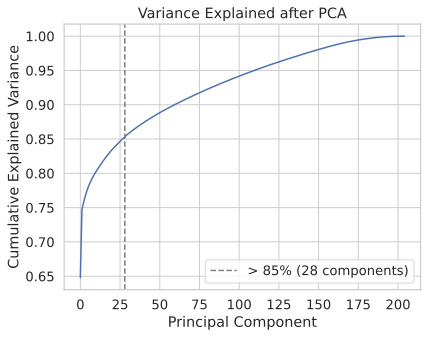

In [22]:
# Plot explained variance
def plot_pca(exp_var_ratios, threshold = 0.85):
    exp_var_cumsum = exp_var_ratios.cumsum()
    t = (exp_var_cumsum < threshold).sum()
    g = sns.lineplot(exp_var_cumsum)
    plt.axvline(x=t+1, ls='--', color='gray', label=f"> 85% ({t+1} components)")

    g.set_title("Variance Explained after PCA")
    g.set_xlabel("Principal Component")
    g.set_ylabel("Cumulative Explained Variance")
    g.legend();
    
    return g

g = plot_pca(exp_variances, threshold = 0.85)

Suppose we are comfortable with a model which uses 85% of the variance in our data. Then we are comfortable saying the remaining 15% of the variation in beer reviews is due to either (a) random noise or (b) beer review "flavors" that are so subtle they are negligible. In this case, we only need to keep 28 components. This is a significant improvement on the original 200+ columns of data.

In [23]:
beers_pca = beers_pca_all[:, :28]

In [24]:
# these correspond to the rows of `df_beers_top`
df_beers_pca = pd.DataFrame(beers_pca, index=df_beers_top.index)

## Similarity

A foundational element of unsupervised learning is the notion of "similarity." The way(s) in which this idea is defined will direct the rest of the algorithm.

In [25]:
from sklearn.metrics import pairwise_distances

There are several similarity (or distance) metrics, but in this lab we'll investigate a few of the most common ones:

- Euclidean Distance
- Cosine Distance
- Jaccard Distance
- Manhattan Distance

Note: "Similarity" is the complement of "Distance". Typically, similarity metrics exist between 0 and 1, so in general, $\text{distance} = 1 - \text{similarity}$.

### Euclidean Distance

The Euclidean Distance represents **the length of the line which connects two points in a vector space**. For two points on the x-y plane, it is the length of the hypotenuse of the triangle formed by the two points and a right angle between them. In general, for two points $p$ and $q$ in $k$-dimensional data, we have

$$
d_E(\mathbf{p}, \mathbf{q})={\sqrt {(p_{1}-q_{1})^{2}+(p_{2}-q_{2})^{2}+\cdots +(p_{k}-q_{k})^{2}}}
$$

*You can think of $\mathbf{p}$ and $\mathbf{q}$ as two rows of data, for instance.*

In [26]:
# three points on the 2-D Euclidean plane
points = [(1, 1),
          (1, 2),
          (4, 2)]

dists = pairwise_distances(points, metric='euclidean', n_jobs=-1)
df_dists = pd.DataFrame(data=dists.round(2), index=points, columns=points)
df_dists
# g = sns.heatmap(df_dists, annot=True, cmap='Blues');

,"(1, 1)","(1, 2)","(4, 2)"
"(1, 1)",0.00,1.0,3.16
"(1, 2)",1.00,0.0,3.00
"(4, 2)",3.16,3.0,0.00


### Cosine Distance

For two points (e.g., rows of data) in the **first quadrant** (i.e., all non-negative values), the Cosine Similarity is **the cosine of the angle between two vectors**. The Cosine *Distance* is 1 minus this value. In general, for two points in $k$-dimensional space, this is

$$
d_C(\mathbf {p}, \mathbf {q})=1 - \cos(\theta )=1 - {\mathbf {p} \cdot \mathbf {q}  \over \|\mathbf {p} \|\|\mathbf {q} \|}=1 - {\frac {\sum \limits _{i=1}^{n}{p_{i}q_{i}}}{{\sqrt {\sum \limits _{i=1}^{n}{p_{i}^{2}}}}\cdot {\sqrt {\sum \limits _{i=1}^{n}{q_{i}^{2}}}}}}
$$

In fact, this is the same thing as 1 minus the (Pearson's) correlation coefficient between $\mathbf{p} = \mathbf{x_1} - \overline{\mathbf{x}}_1$ and $\mathbf{q} = \mathbf{x_2} - \overline{\mathbf{x}}_2$ for some vectors $\mathbf{x}$ and $\mathbf{y}$.

In [27]:
points = [(1, 1),
          (1, 2),
          (2, 4)]

dists = pairwise_distances(points, metric='cosine', n_jobs=-1)
pd.DataFrame(data=dists.round(2), index=points, columns=points)

,"(1, 1)","(1, 2)","(2, 4)"
"(1, 1)",0.00,0.05,0.05
"(1, 2)",0.05,0.00,0.00
"(2, 4)",0.05,0.00,0.00


### Jaccard Distance

The [Jaccard Similarity](https://en.wikipedia.org/wiki/Jaccard_index) is a consideration of two vectors as if they were sets of items. It represents **the proportion of elements shared between two sets of data.** The more items they share (e.g., maybe each column represents a binary indicator of an item), the higher the Jaccard Similarity. *Note: This measure makes the most sense for binary data.* The Jaccard *Distance* is 1 minus this value:

$$
d_J(\mathbf{p}, \mathbf{q}) = 1 - {|\mathbf{p} \cap \mathbf{q}| \over |\mathbf{p} \cup \mathbf{q}|}
$$

In [28]:
points_tuples = [(0, 0, 1),
                 (1, 1, 0),
                 (1, 1, 1)]

# in sklearn, jaccard distance requires boolean data
points = np.array(points_tuples).astype(bool)

dists = pairwise_distances(points, metric='jaccard')
pd.DataFrame(data=dists.round(2), index=points_tuples, columns=points_tuples)

,"(0, 0, 1)","(1, 1, 0)","(1, 1, 1)"
"(0, 0, 1)",0.00,1.00,0.67
"(1, 1, 0)",1.00,0.00,0.33
"(1, 1, 1)",0.67,0.33,0.00


### Manhattan Distance

Manhattan Distance, or Taxicab Distance is **the sum of the perpendicular distances along the axes of a vector space, between two points.** So, in two dimensions, it is the total "horizontal" + "vertical" distance between two points.

$$
{\displaystyle d_{\text{T}}(\mathbf {p} ,\mathbf {q} )=\sum _{i=1}^{n}\left|p_{i}-q_{i}\right|}
$$

In [29]:
points = [(1, 1),
          (1, 2),
          (4, 2)]

dists = pairwise_distances(points, metric='manhattan', n_jobs=-1)
pd.DataFrame(data=dists.round(2), index=points, columns=points)

,"(1, 1)","(1, 2)","(4, 2)"
"(1, 1)",0.0,1.0,4.0
"(1, 2)",1.0,0.0,3.0
"(4, 2)",4.0,3.0,0.0


## Clustering

Suppose we had 100 rows of data with two columns: `purchases_per_month` and `spend_per_month`. Consider the following, for a possible scenario. *Note: this is generated data.*

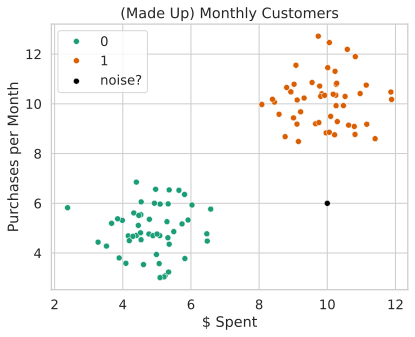

In [30]:
from sklearn.datasets import make_blobs

centers = [(5, 5), (10, 10)]

blobs, blob_labels = make_blobs(n_samples=100, n_features=2, cluster_std=1.0,
                                centers=centers, shuffle=False, random_state=42)

g = sns.scatterplot(x=blobs[:, 0], y=blobs[:, 1], hue=blob_labels, 
                    palette='Dark2')
sns.scatterplot(x=[10], y=[6], label='noise?', color='black')

g.set_xlabel('$ Spent')
g.set_ylabel('Purchases per Month')
g.set_title("(Made Up) Monthly Customers");

Visually, we can divide these data into two groups based on their features. Maybe the bottom group represents "frugal" customers, and the top group could be "lavish" customers. But, computationally, the question is a bit more difficult, *especially* when it comes to data with more than three columns.

The purpose of clustering is to use the features of our data to computationally assign each observation to a group, based on some kind of similarity metric. Technically, the term **clustering** refers to grouping data in such a way there could be points leftover; we may call these points "noise". **Partitioning** on the other hand, partitions the data in such a way that *every* point is assigned to one partition. We typically use the term "clustering" to accont for both of these.

In this lab, we will cover the k-Means algorithm, which is still one of the most scalable and interpretable algorithms.

In [31]:
from sklearn.cluster import KMeans

### k-Means

k-Means clustering is a **partitioning** algorithm that divides data into $k$ clusters. Points are assigned to a cluster based on similarity to nearest cluster centroid. The value of $k$ is chosen by the user as a hyperparameter for the algorithm.

    1. Choose `k` centroids (e.g., randomly)
    2. Assign points to cluster based on nearest centroid
    3. Recompute centroids based on each cluster's "average" point
    4. Repeat steps (2) and (3) until algorithm converges

*Interestingly, the boundary regions for KNN can always be reduced to a specific [Vonoroi Diagram](https://en.wikipedia.org/wiki/Voronoi_diagram).*

In [32]:
# suppose we start with 5 clusters (arbitrary at the start)
num_clusters = 5

km = KMeans(n_clusters=num_clusters, n_init='auto')
km.fit(df_beers_pca)

,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [33]:
df_beers_top['cluster_kmeans'] = km.labels_.astype(str)

In [34]:
df_beers_top[['beer_style', 'cluster_kmeans']].sample(5)

,beer_style,cluster_kmeans
beer_id,,
Highland Pale Ale (39117),American Pale Ale (APA),2
Slacker Pale Ale (12442),American Pale Ale (APA),2
Slave Princess (36187),American Porter,2
Bloemenbier (21532),Herbed / Spiced Beer,1
Greenman Grogg (32214),American Pale Ale (APA),0


**Strengths:**
1. Simple parameter ($k$ clusters)
2. Relatively fast for $n$ points in $d$-dimensions. The runtime is $O(nkdi)$ where $i$ is number of iterations until convergence.
3. Guaranteed to converge.
4. Easy to implement.

**Weaknesses:**
1. Optimal $k$ is often not obvious.
2. Can get trapped in local minima (initial conditions matter).
3. Sensitive to outliers (partitioning not clustering).
4. Scaling affects results.

### Evaluation

There are many different ways to evaluate a clustering algorithm, but here we'll just discuss the following methods:

- Inertia
- Plots

#### Inertia

Inertia roughly translates to "good clustering = points are close to cluster centroids". In essence, we calculate the (squared) Euclidean Distance between each point and their closest centroids, add them up, and call this "inertia". In fact, minimizing this is the main goal of the k-Means algorithm.

$$
I = \sum_{i = 0}^n\min_{\bar{x}_j\in C}\left(\|x_i - \bar{x}_j\|^2\right)
$$

where $x_i$ is each point in the data, $\bar{x}_j$ represents the "average" centroid point of cluster $j$, and $C$ is the collection of all clusters. We want $I$ to be as small as possible. *Note: $I \geq 0$, and $I = 0$ only when all points in a cluster lie at the same location, or the number of clusters = number of points.*

In [35]:
km.inertia_

20419.390861787964

In [36]:
inertias = []

for num_clusters in range(2, 12):
    km = KMeans(n_clusters=num_clusters, n_init='auto')
    km.fit(df_beers_pca)
    
    inertias.append(km.inertia_)

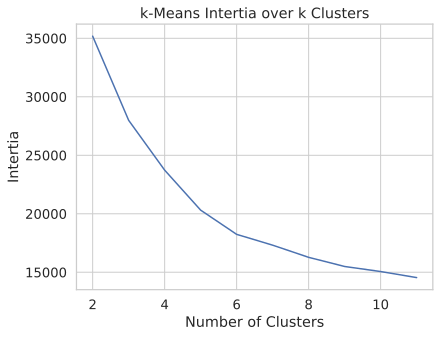

In [37]:
g = sns.lineplot(x=range(2, 12), y=inertias)
g.set_xlabel('Number of Clusters')
g.set_ylabel("Intertia")
g.set_title("k-Means Intertia over k Clusters");

A good rule of thumb for picking the best value in a situation like this is to use the ["elbow" method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). Essentially, this is the point at which the inertia decreases with diminishing returns. In our case, it looks like our selection of $k=5$ clusters is best for now.

#### Plotting

Of course, another great method for scrutinizing clusters is directly plotting the relationships between the clusters you've built and the data themselves. **The plots are up to you, and depend on your data**, but here we'll look at just the top styles of beer, for example.

In [38]:
# top 5 breweries
mask = df_beers_top['beer_style'].value_counts().index[:5]
mask = df_beers_top['beer_style'].isin(mask)

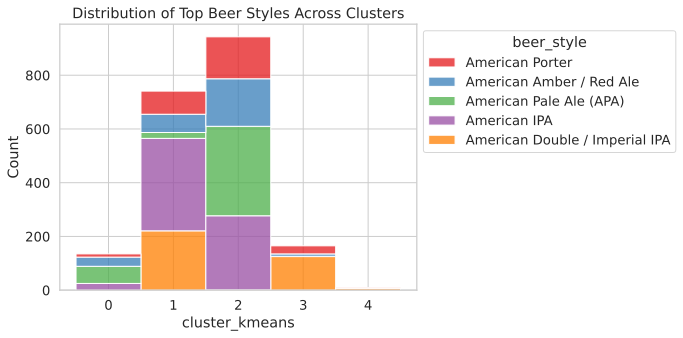

In [39]:
g = sns.histplot(data=df_beers_top[mask].sort_values('cluster_kmeans'),
                 x='cluster_kmeans', 
                 hue='beer_style', palette='Set1', multiple='stack')

g.set_title('Distribution of Top Beer Styles Across Clusters')

sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

Here, we can see the some styles of beer are more prevalent in some clusters than others.

## Recommender Systems

A recommender system is an automated system that seeks to suggest whether a given item will be desirable to a user. These are algorithms that aim to provide the most relevant items to a user by **filtering useful information from noise.** For example, suppose there are too many books at the bookstore to browse at once. Let's say I’ve bought a few books related to poetry. In this case, a book recommender system might:

    1. Log the interest in poetry
    2. Review other customers’ interests
    3. Reference meta-information on all its books and customers
    4. Suggest a set of products
    
There are two kinds of recommendation:

- Content-Based Filtering
- Collaborative Filtering

We can also combine these two into a sort of "hybrid" method.

### Content-Based Filtering

With Content-Based Filtering, we define relevance using only item information. All we’d need is a matrix of items and their attributes. I.e., we project items into their feature space. The recommendation comes from item similarity. In this case, our definition of similarity is crucial.

#### Calculate Pairwise Distances

In [ ]:
# Try metric='euclidean' and metric='cosine', and see what changes!
dists = pairwise_distances(df_beers_pca, metric='cosine')
dists.shape

In [ ]:
# Numpy outputs an array here, so we want to get the names of the beers back
dists = pd.DataFrame(data=dists, 
                     index=df_beers_pca.index, 
                     columns=df_beers_pca.index)

In [ ]:
dists.iloc[0:5, 0:5]

#### Devise "Ranking" Scheme

**Here is where we can get creative!**

Let's say that a user has three beers that they like. We're going to say that a 'likeable' beer is one which is relatively close to all three of these beers. That is, the *sum* of the distances bewteen the 'likeable' beer and the three liked beers is minimal.

Start by selecting three beers and store them in `beers_i_like` then look their distances to other beers.

In [ ]:
beers_i_like = ['Belgian Blonde (44506)', 'ÜberFest Pilsner (39361)', '"Cellar Reserve" Triple Gold (25108)']

# view distances across the first 10 rows
dists[beers_i_like].head(10)

Now, we sum each of the distances to the favorite beers by row. That is, we are summing 3 numbers for each row.

In [ ]:
beers_summed = dists[beers_i_like].sum(axis=1)

In [ ]:
beers_summed = beers_summed.sort_values(ascending=True)
beers_summed.head()

In [ ]:
# Filter out the beers used as input using `.isin()`
mask = ~beers_summed.index.isin(beers_i_like)
ranked_beers = beers_summed.index[mask]
ranked_beers = ranked_beers.tolist()

ranked_beers[:5]

Note that the similarity here is not just based on the attributes of reviews (e.g., `beer_type`, `abv`, etc.), but it is based on the "beer review flavors" from PCA. In other words, two beers will be similar if they are correlated with the same kinds of "beer review flavors" (i.e., the same feature behaviors).

#### Evaluation

One way to evaluate a recommender system such as this one is to compare the features of the preferred items to the ones which have been recommended.

In [ ]:
beers_i_like

In [ ]:
# top 5 recommendations
recommendations = ranked_beers[:5]
recommendations

In [ ]:
df_eval = df_beers_top.copy()

# Use `np.where` to create a categorical variable based on boolean series
df_eval['rec_label'] = np.where(df_eval.index.isin(beers_i_like), 'Like',
                       np.where(df_eval.index.isin(recommendations), 'Recommended',
                       'Other'))

In [ ]:
df_eval[df_eval.rec_label.isin(['Like', 'Recommended'])] \
        .sort_values('rec_label')

In a way, this makes sense. Let's put this into a function, and see how things change with new beers and distance metrics

In [ ]:
def recommend_beers(beers_i_like, df_pca, num_recs=5, metric='euclidean'):
    # calculate pairwise distances
    dists = pairwise_distances(df_pca, metric=metric)
    dists = pd.DataFrame(data=dists, index=df_pca.index, columns=df_pca.index)
    
    # ranking scheme
    beers_summed = dists[beers_i_like].sum(axis=1)
    beers_summed = beers_summed.sort_values(ascending=True)
    
    # remove preferred beers
    ranked_beers = beers_summed.index[~beers_summed.index.isin(beers_i_like)]
    ranked_beers = ranked_beers.tolist()
    
    # get recommendations (top-ranked)
    recommendations = ranked_beers[:num_recs]
    print("Recommendations: ")
    print('\t' + '\n\t'.join(recommendations))
    
    return recommendations

def rec_eval(beers_i_like, recommendations, df_features):
    df_eval = df_features.copy()

    df_eval['rec_label'] = np.where(df_eval.index.isin(beers_i_like), 'Like',
                                    np.where(df_eval.index.isin(recommendations), 'Recommended',
                                             'Other'))
    
    df_eval = df_eval[df_eval.rec_label.isin(['Like', 'Recommended'])] \
                        .sort_values('rec_label')
    
    return df_eval

With Euclidean distance ...

In [ ]:
recommendations = recommend_beers(beers_i_like, 
                                  df_pca=df_beers_pca, 
                                  metric='euclidean')

In [ ]:
rec_eval(beers_i_like, recommendations, df_beers_top)

With Cosine distance ...

In [ ]:
recommendations = recommend_beers(beers_i_like,
                                  df_pca=df_beers_pca,
                                  metric='cosine')

In [ ]:
rec_eval(beers_i_like, recommendations, df_beers_top)

**Caveats of Content-Based Filtering**

- Recommendations biased toward past user preference
    - Consider the feedback loop …
- Diversity of recommendation space is diminished
    - We can only work within neighborhoods of past items
- Cross domain recommendations are difficult
    - Think about recommending movies based on podcasts

### Collaborative

Here, we use other users’ history to predict new users’ preference. We define relevance using only user-item relationships, based on a user-item matrix containing `review_overall` ratings as values.

In [ ]:
# Let's restrict our dataset to the top reviewers.
n = 100

# The number of beers reviewed for each user
reviewer_counts = df_beer_reviews.groupby('review_profilename')['beer_beerid'] \
                                 .nunique().sort_values(ascending=False)

top_n_reviewers = reviewer_counts.index[:n]

# this is the data we want
df_filtered = df_beer_reviews[df_beer_reviews['review_profilename'] \
                              .isin(top_n_reviewers)].copy()
df_filtered.shape

In [ ]:
df_filtered[['beer_beerid', 'beer_name', 
             'review_profilename', 'review_overall']].head()

#### Collect Users as Features

What we want is a matrix with users on one axis (e.g., columns), and items on the other axis (e.g., rows). Here, we start by grouping our data to get an aggregate reprsentative value for each item-user combination, and then use `unstack` to widen the data.

In [ ]:
# create a useful index
df_filtered['beer_id'] = df_filtered['beer_name'] + ' (' \
    + df_filtered['beer_beerid'].astype(str) + ')'

In [ ]:
# For each beer (row), what is the average review score for each user (column)
df_beer_user = (df_filtered
                .groupby(["beer_id", "review_profilename"])['review_overall']
                .mean())
df_beer_user.head()

In [ ]:
# convert to a wide version
df_beer_user = df_beer_user.unstack()

df_beer_user.head()

In [ ]:
df_beer_user.isna().sum() / df_beer_user.shape[0]

**How should we handle missing values here?** What does it mean for a beer *not* to be reviewed by a user? Should we treat these the same as the situations where a user reviewed a beer, and rated it zero? What if we used a negative number, how would that affect our distances/similarities between beer-user entities? What if we used the average value for each column, can we assume that a beer unreviewed by user $x$ will have their average beer rating?

What if we assume (for the time being) that an unreviewed beer has an (impossible) rating of -1. This way, we can capture the fact that user hasn't reviewed that beer. It also comes in handy later when trying to spot the beers that have been rated vs. those which have not.

In [ ]:
df_beer_user.fillna(-1, inplace=True)

Recall that Singular Value Decomposition (SVD) is a method we can use to understand latent "topic directions" in text data. So, given a document-term matrix, we can get an idea for the kinds of topics that exist in the data (i.e., the ways words are correlated across documents). With our user-item data, we can use SVD to understand sort of "*usage* directions". In this way, given a user-item matrix, we get an idea for the ways items are correlated across users given our data set.

<center>
    <img width='65%' src="https://docs.google.com/drawings/d/e/2PACX-1vQ2EGkUO7gDlYxhzqfFudz4MeFAtefwahuML0Gu3mRQ-oNrMK9hGkA3a-Dhkq5Sx5zrbjuJen-7_7iP/pub?w=960&h=720">
</center>

Traditionally, we'll want to reduce our number of *usage directions* (i.e., the number of principal components we consider) to some number less than the total number of users in our data set. This way, we can look at our data from the perspective of usage (the directions) and weights with which they're associated (how strongly a user/item is correlated in a direction). *In fact, we can use these weights to assign users (or items, for that matter) to groups.*

[SciPy](https://docs.scipy.org/doc/scipy/index.html) is another Python library we will see more of in a later lesson. It's built to manage all kinds of mathematical operations such as linear algebra, signal processing, etc. Here, we'll use it's implementation of SVD so that we can capture all three of these matrices $U$, $\Sigma$, and $V$, since SKLearn's `PCA` only gives us the first two matrices.

In [ ]:
from scipy.linalg import svd

In [ ]:
beer_usage, usage, usage_user = svd(df_beer_user, full_matrices=False)

In [ ]:
# For each beer, how much of their use (rating) is captured by each usage type?
df_beer_usage = pd.DataFrame(data=beer_usage, index=df_beer_user.index)

In [ ]:
# For each user, how much of their activity is captured by each usage (rating scheme) type?
df_usage_user = pd.DataFrame(data=usage_user, columns=df_beer_user.columns)
df_user_usage = df_usage_user.T

- `df_beer_usage` is now a matrix where each row represents a beer, and each column represents a kind of *usage*. If we look at any row (beer), the columns tell us how much information about that beer can be gathered solely by looking at it's usage along each usage type
- `df_user_usage` is a matrix where each row is a kind of usage, and the columns are users. Similar to the above, it tells us how much information about that user can be gathered just by looking at their activity in some usage type.
- `usages` contains the sort of variety of users/beers that are represented by each usage type. 

#### Similar User Activity

Recall that the `usages` came from `svd`, and it represents the singular values (the *weights*) of the Singular Value Decomposition. Each singular value tells us *how much* a principal component ("usage type") tells us about the user or item. So, naturally, if we take any singular value `usage[i]` and divide it by the sum of all the usages `usage[i] / usage.sum()`, we have the amount of "explained variance" that the `i`th singular value provides. 

Also, `usages` is **naturally sorted** in descending order by the `svd` algorithm.

In [ ]:
# plot the explained variance of each of these usage types
exp_var_ratios = usage / usage.sum()

g = plot_pca(exp_var_ratios, threshold = 0.85)

Notice that it takes many more principle components to capture 85% of the variance in this data. In other words, there are about 80 different ways to review beer that are relatively (i.e., "85%") distinct from one another.

In [ ]:
# To keep 85% of the variance, let's consider the first 80 usage types (principal components)
dists_users = pairwise_distances(df_user_usage.iloc[:, :80], metric='euclidean')
dists_users = pd.DataFrame(dists_users, index=df_user_usage.index, 
                           columns=df_user_usage.index)

In [ ]:
def get_user_neighbors(user, neighborhood=10):
    '''
    Given a user, return the closest users by the `dists_users` matrix
    '''
    neighbors = dists_users[user].sort_values()[:neighborhood]
    
    return neighbors

Consider a singular user, and their closest neighbors when we consider their "usage" type:

In [ ]:
df_user_usage.index[1]

In [ ]:
# for example
neighbors = get_user_neighbors('BEERchitect')
neighbors.round(3)

**Active Reviewers**

Recall that we encoded a negative rating to mean that the user did not review that beer. So, we'll gather the "active" reviewers by capturing the rows with the most non-negative values, and sorting them in descending order.

In [ ]:
# count non-negative values (i.e., beers with reviews), and sort
top_users = (df_beer_user > 0).sum(axis=0) \
                              .sort_values(ascending=False).index[:10]
top_users

**Check**

Let's create a plot with the known ratings of the user in question along with ratings of the same beers given by the neighbors we calculated above.

In [ ]:
def plot_usage(user, neighborhood=10):
    # Get the `neighborhood` closest neighbors
    neighbors = get_user_neighbors(user, neighborhood).index.tolist()
    
    # build array of review values for beers reviewed by neighbors
    mask = df_filtered['review_profilename'].isin(neighbors)
    df_plot = df_filtered[mask][['review_profilename', 
                                 'beer_style', 
                                 'review_overall']]
    df_plot = (
        df_plot
        .groupby(['beer_style', 'review_profilename'])['review_overall']
        .mean().unstack())

    df_plot = df_plot.loc[:, neighbors] \
                     .sort_values(user, ascending=False) \
                     .dropna(how='all')
    
    # We'll only annotate the heatmap if the text is easier to see
    df_annot = df_plot.round(2) if df_plot.shape[0] <= 20 else None
    
    # We're sure to be intentional about a "center" point
    plt.title(f"Top Ratings for Neighbors of {user}")
    sns.heatmap(df_plot,
                annot=df_annot,
                cmap='coolwarm_r',
                center=3);  # ratings range from 1-5, and 3 is center

In [ ]:
plot_usage('mikesgroove')

Based off this, could we conclude this is a good recommender?

#### Recommendation

Say for some user, we take the top `m` closest users, and recommend `r` different beers

In [ ]:
user = 'dyan'

In [ ]:
# We consider the 20 closest users (reviewers) to choose untried beers
n_neighbors = 20

neighbors = get_user_neighbors(user, n_neighbors+1)
neighbors = neighbors[1:]  # We don't want to include the user themself
neighbors

In [ ]:
# Look at *untried* beers among the neighboring users
untried_beers = df_beer_user[user] < 0
df_rec = df_beer_user.loc[untried_beers, neighbors.index].copy()

# Replace the un-rated beers with NAN values
df_rec = df_rec.replace(-1, np.nan)  

# Only keep rows where at least one neighbor rated the beer
df_rec = df_rec.dropna(how='all')

df_rec

In [ ]:
# Get the average rating among the top `n_neighbors` of our user (ignoring NaNs)
# (HOW COULD WE SMARTER ABOUT THIS?)
avg_beer_rating = np.nanmean(df_rec, axis=1)
avg_beer_rating = pd.Series(index=df_rec.index, data=avg_beer_rating)
avg_beer_rating.sort_values(ascending=False, inplace=True)

# Return up to `n_recommendations`
n_recommendations = 5
avg_beer_rating[:n_recommendations]

In [ ]:
# Put all this into a function
def get_recommendations(user, n_recommendations=5, n_neighbors=20):
    neighbors = get_user_neighbors(user, n_neighbors+1)
    neighbors = neighbors[1:]  # We don't want to include the user themselves
    
    untried_beers = df_beer_user[user] < 0
    df_rec = df_beer_user.loc[untried_beers, neighbors.index].copy()

    df_rec = df_rec.replace(-1, np.nan)  # Replace the un-rated beers with NAN values
    df_rec = df_rec.dropna(how='all')  # Only keep rows where at least one neighbor rated the beer
    
    # Get the average rating among the top `n_neighbors` of our user
    avg_beer_rating = np.nanmean(df_rec, axis=1)
    avg_beer_rating = pd.Series(index=df_rec.index, data=avg_beer_rating)
    avg_beer_rating.sort_values(ascending=False, inplace=True)

    # Return up to `n_recommendations`
    return avg_beer_rating[:n_recommendations]

In [ ]:
user = 'Thorpe429'

In [ ]:
get_recommendations(user)

# Explore

Test your understanding of this week's content with the following explorations.

*Note: unless otherwise noted, **explorations are completely optional and will not be reviewed.***

## Exploration 1

Write a function called `euclidean` which calculates the Euclidean distance between two points (of any `k` dimensions), using only vanilla Python (no packages). This should return a single value.

**(Optional)** Adjust your function to calculate *pairwise* Euclidean distances for any number of points (i.e., return a matrix).

## Exploration 2

Let `r` be some value **less** than `df_user_usage.shape[1]`. For example, the `r` above corresponds to roughly 85% of the variance in the user data.

Use your function from Exercise 1 and the `df_user_usage.iloc[:, :r]` dataframe to calculate the distance between any two users. Interpret your results for a random selection of two users compared to another selection of two *other* users.


#### Bonus

*Note: This requires some mathematical understanding of SVD.*

Set `r = None`. Given the fact that `df_user_usage` came **after** PCA, explain the distances calculated in Exercise 2.